In [0]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import GRU, Dense
import math
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")

## Time Series Prediction using LSTM

### Download Data
Link: https://datamarket.com/data/set/2324/daily-minimum-temperatures-in-melbourne-australia-1981-1990#!ds=2324&display=line

#### Description
Daily minimum temperatures in Melbourne, Australia, 1981-1990

Units: Degrees Celcius

#### Steps before loading
- Rename the column name with temprature values to "Temprature"
- In the last, there is one extra row in the data, remove it by opening the file and save it again.
- There are some values in Temprature column which have a "?" before them, they will give error, remove "?" before them and save the file
- If you don't want to do these steps, just load the data file given by Great Learning.

#### Mount google drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


#### Change your present working directory

In [4]:
import os
os.chdir('/content/drive/My Drive/PGPAIML/Internal Lab Residency 10')
!pwd
!ls

/content/drive/My Drive/PGPAIML/Internal Lab Residency 10
daily-minimum-temperatures-in-me.csv
time_series_prediction_lstm_melbourne_daily_temprature_data_questions.ipynb


### Load your data file

In [5]:
df = pd.read_csv('daily-minimum-temperatures-in-me.csv')
df.head()

,Date,Temperature
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


#### Plot data

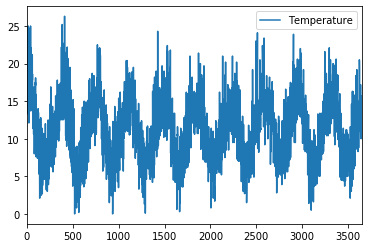

In [6]:
df.plot()

#### Descibe your dataframe

In [7]:
df.describe()

,Temperature
count,3650.000000
mean,11.177753
std,4.071837
min,0.000000
25%,8.300000
50%,11.000000
75%,14.000000
max,26.300000


#### Check for null values

In [8]:
df.isnull().sum()

Date           0
Temperature    0
dtype: int64

#### Drop null values

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 2 columns):
Date           3650 non-null object
Temperature    3650 non-null float64
dtypes: float64(1), object(1)
memory usage: 57.2+ KB


#### Get the representation of the distribution of data in the form of histogram

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f68c0e50400>]],
      dtype=object)

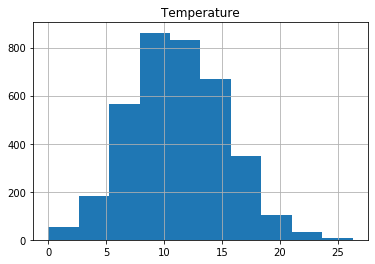

In [10]:
df.hist(bins=10)

#### Check the maximum and minimum values

In [11]:
print('Min : ', np.min(df))
print('Max : ', np.max(df))

Min :  Date           1981-01-01
Temperature             0
dtype: object
Max :  Date           1990-12-31
Temperature          26.3
dtype: object


### Normalize the data

In [0]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df[['Temperature']])

#### Check the maximum and minimum values of scaled data

In [13]:
print('Min', np.min(scaled))
print('Max', np.max(scaled))

Min 0.0
Max 1.0


#### Look into some of the scaled values

In [29]:
scaled[1:10]

array([[0.68060837],
       [0.71482889],
       [0.55513311],
       [0.60076048],
       [0.60076048],
       [0.60076048],
       [0.66159696],
       [0.82889733],
       [0.7604563 ]])

### Split data into Training and Testing

In [0]:
train_size = int(len(scaled) * 0.70)
test_size = len(scaled - train_size)
train, test = scaled[0:train_size, :], scaled[train_size: len(scaled), :]

#### Print train and test size

In [15]:
print('train: {}\ntest: {}'.format(len(train), len(test)))

train: 2555
test: 1095


## Create the sequential data
Map the temprature at a particular time t to the temprature at time t+n, where n is any number you define.

For example: to map tempratures of consecutive days, use t+1, i.e. loop_back = 1

#### Define your function to create dataset

In [0]:
def create_dataset(dataset, look_back=1):
    print(len(dataset), look_back)
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        print(i)
        print('X {} to {}'.format(i, i+look_back))
        print(a)
        print('Y {}'.format(i + look_back))
        print(dataset[i + look_back, 0])
        dataset[i + look_back, 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

#### Use function to get training and test set

In [18]:
look_back = 1
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

2555 1
0
X 0 to 1
[0.78707224]
Y 1
0.6806083650190113
1
X 1 to 2
[0.68060837]
Y 2
0.714828897338403
2
X 2 to 3
[0.7148289]
Y 3
0.5551330798479087
3
X 3 to 4
[0.55513308]
Y 4
0.6007604562737643
4
X 4 to 5
[0.60076046]
Y 5
0.6007604562737643
5
X 5 to 6
[0.60076046]
Y 6
0.6007604562737643
6
X 6 to 7
[0.60076046]
Y 7
0.6615969581749048
7
X 7 to 8
[0.66159696]
Y 8
0.8288973384030418
8
X 8 to 9
[0.82889734]
Y 9
0.7604562737642585
9
X 9 to 10
[0.76045627]
Y 10
0.6159695817490494
10
X 10 to 11
[0.61596958]
Y 11
0.5057034220532319
11
X 11 to 12
[0.50570342]
Y 12
0.6349809885931559
12
X 12 to 13
[0.63498099]
Y 13
0.8174904942965779
13
X 13 to 14
[0.81749049]
Y 14
0.9505703422053232
14
X 14 to 15
[0.95057034]
Y 15
0.7870722433460076
15
X 15 to 16
[0.78707224]
Y 16
0.7832699619771863
16
X 16 to 17
[0.78326996]
Y 17
0.9429657794676806
17
X 17 to 18
[0.94296578]
Y 18
0.6730038022813688
18
X 18 to 19
[0.6730038]
Y 19
0.5893536121673003
19
X 19 to 20
[0.58935361]
Y 20
0.6920152091254752
20
X 20 to 21


#### Transform the prepared train and test input data into the expected structure using numpy.reshape()

In [19]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_train.shape)
print(X_test.shape)

(2553, 1, 1)
(1093, 1, 1)


## Define Model

### Define sequntial model, add LSTM layer and compile the model

In [0]:
batch_size = 1
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

### Summarize your model

The network has a visible layer with 1 input, a hidden layer with 4 LSTM blocks or neurons, and an output layer that makes a single value prediction. The default sigmoid activation function is used for the LSTM blocks. The network is trained for 50 epochs and a batch size of 1 is used.

In [32]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (1, 4)                    96        
_________________________________________________________________
dense_2 (Dense)              (1, 1)                    5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


### Train the model

In [26]:
model.fit(X_train, y_train, epochs=50, batch_size=batch_size, verbose=2, shuffle=True)

Epoch 1/50
 - 4s - loss: 0.0127
Epoch 2/50
 - 4s - loss: 0.0115
Epoch 3/50
 - 4s - loss: 0.0108
Epoch 4/50
 - 4s - loss: 0.0105
Epoch 5/50
 - 4s - loss: 0.0105
Epoch 6/50
 - 4s - loss: 0.0105
Epoch 7/50
 - 4s - loss: 0.0104
Epoch 8/50
 - 4s - loss: 0.0104
Epoch 9/50
 - 4s - loss: 0.0104
Epoch 10/50
 - 4s - loss: 0.0104
Epoch 11/50
 - 4s - loss: 0.0103
Epoch 12/50
 - 4s - loss: 0.0104
Epoch 13/50
 - 4s - loss: 0.0104
Epoch 14/50
 - 4s - loss: 0.0103
Epoch 15/50
 - 4s - loss: 0.0104
Epoch 16/50
 - 4s - loss: 0.0104
Epoch 17/50
 - 4s - loss: 0.0104
Epoch 18/50
 - 4s - loss: 0.0104
Epoch 19/50
 - 4s - loss: 0.0103
Epoch 20/50
 - 4s - loss: 0.0103
Epoch 21/50
 - 4s - loss: 0.0104
Epoch 22/50
 - 4s - loss: 0.0103
Epoch 23/50
 - 4s - loss: 0.0103
Epoch 24/50
 - 4s - loss: 0.0103
Epoch 25/50
 - 4s - loss: 0.0103
Epoch 26/50
 - 4s - loss: 0.0102
Epoch 27/50
 - 4s - loss: 0.0103
Epoch 28/50
 - 4s - loss: 0.0102
Epoch 29/50
 - 4s - loss: 0.0104
Epoch 30/50
 - 4s - loss: 0.0103
Epoch 31/50
 - 4s -

## Make Predictions and Evaluate your model

In [27]:
trainPredict = model.predict(X_train, batch_size=batch_size)

model.reset_states()

testPredict = model.predict(X_test, batch_size=batch_size)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
y_train = scaler.inverse_transform([y_train])
testPredict = scaler.inverse_transform(testPredict)
y_test = scaler.inverse_transform([y_test])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 2.63 RMSE
Test Score: 2.47 RMSE


## Plot the results

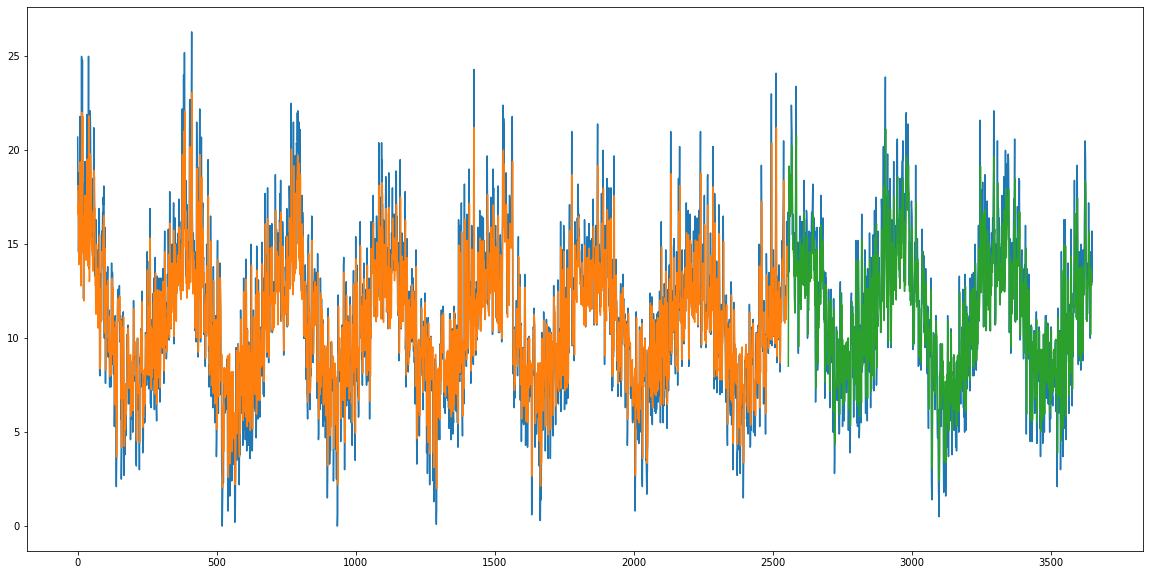

In [30]:
trainPredictPlot = np.empty_like(scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(scaled)-1, :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(20,10))
plt.plot(scaler.inverse_transform(scaled))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()